## Data Analysis and Preprocessing

## Functions

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tableone import TableOne
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.models import Sequential
import tensorflow as tf

Functions that modify the Datasets

In [3]:
def impute_missing(data_sensors, column):
    before_imputation = data_sensors.copy()

    for index, row in data_sensors.iterrows():
        if pd.isna(row[column]):
            #prev row
            prev = data_sensors.loc[:index].loc[~data_sensors[column].isna()].tail(1)
            #next row
            next = data_sensors.loc[index:].loc[~data_sensors[column].isna()].head(1)

            if not (prev.empty or next.empty):
                mean = round((prev[column].values[0] + next[column].values[0]) / 2, 2)
                data_sensors.at[index, column] = mean

    
    changes = pd.DataFrame(columns=['Index', 'before', 'after'])
    for index, row in before_imputation.iterrows():
        before = row[column]
        after = data_sensors.at[index, column]
        if pd.notna(before) and pd.notna(after) and before != after:
            changes = changes.append({'Index': index, 'before': before, 'after': after}, ignore_index=True)

    return data_sensors, changes

def rename_sensor(data_sensors):

    sensor_ids = ['am3019-testqc2090', 'am307-9074', 'eui-24e124128c147204',
                  'eui-24e124128c147444', 'eui-24e124128c147446',
                  'eui-24e124128c147470', 'eui-24e124128c147499',
                  'eui-24e124128c147500', 'eui-24e124710c408089',
                  'eui-24e124725c461468', 'q4-1003-7456']
    #We will not use Biblio_Filo and AudioLab Data
    sensors_names = ['testqc2090', 'Computer_Room', 'Digital_Lab',
                  'Biblio_Filo', '24e124128c147446',
                  '24e124128c147470', 'AudioLab',
                  'OpenLab_Main_Room', 'OpenLab_Laser_Room',
                  '24e124725c461468', 'Classroom']
    
    mapp = dict(zip(sensor_ids, sensors_names))
    data_sensors['location'] = data_sensors['location'].map(mapp).fillna(data_sensors['location'])
    
    data_sensors = data_sensors[(data_sensors['location'] != 'Biblio_Filo') & (data_sensors['location'] != 'AudioLab')]
    
    return data_sensors

def get_season(month):
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def get_time_of_day(hour):
    hour = int(hour)
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
def combine_dataframes(sensor_name,data_meteo):
    data_meteo['DateTime'] = pd.to_datetime(data_meteo['Date'] + ' ' + data_meteo['Hour'])
    
    sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])

    #round the hours to the nearest multiple of 30 minutes
    sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')

    #combine Dataframes by datetime column
    combined = pd.merge(sensor_name, data_meteo, on='DateTime', how='inner')
    combined = combined.drop(columns=["DateTime","Date_y", "Hour_y", "location"])

    combined.rename(columns={'Date_x': 'Date'}, inplace=True)
    combined.rename(columns={'Hour_x': 'Hour'}, inplace=True)
    combined.rename(columns={'TM': 'TM_outdoor'}, inplace=True)
    combined.rename(columns={'HRM%': 'HRM%_outdoor'}, inplace=True)
    combined.rename(columns={'PPT': 'PPT_outdoor'}, inplace=True)
    combined.rename(columns={'RS': 'RS_outdoor'}, inplace=True)
    combined[['Hour', 'Minutes']] = combined['Hour'].str.split(':', expand=True)
    
    #combined['Minutes'] = combined['Minutes'].astype(int)
    combined[['Day', 'Month', 'Year']] = combined['Date'].str.split('-', expand=True)
    #combined['Day'] = combined['Day'].astype(int)
    #combined['Year'] = combined['Year'].astype(int)
    
    #....................................................................
    #Let's create more columns to identify the seasons and time of day
    combined['Season'] = combined['Month'].apply(get_season)
    combined['Time_of_Day'] = combined['Hour'].apply(get_time_of_day)
    
    #OrdinalEncoder - convert categorical data in numerical
    encoder = OrdinalEncoder()
    combined[['Season', 'Time_of_Day']] = encoder.fit_transform(combined[['Season', 'Time_of_Day']])

    #....................................................................
    #We have to divide the ones that have the illumination column and the ones that have light_level
    if 'light_level' in combined.columns:
        combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day','light_level' ,'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]
    elif 'illumination' in combined.columns:
        combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day','illumination' ,'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]
    
    #....................................................................
    #combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day', 'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]

    return combined


Functions to plot

In [4]:
def display_plot(data,x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();


def display_outliers(sensor_com):
    sensor_com = sensor_com.drop('light_level', axis=1)
    num_feats = [col for col in sensor_com.columns if sensor_com[col].dtype != 'object']

    fig, axes = plt.subplots(nrows=len(num_feats)//2, ncols=2, figsize=(16, 8 * (len(num_feats)//2)))
    axes = axes.flatten()

    #iterate over numerical features
    for i, col in enumerate(num_feats):
        #boxplot for each feature
        sb.boxplot(x=sensor_com[col], color='red', ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

## LOAD

We have loaded the dataframes and modified the formats so that they are similar

In [5]:
data_meteo = pd.read_excel("C:/Users/migue/UAB_EnergyStudy/DataSets_/Meteo - Sensors Data/datos_meteo.xlsx")

data_meteo['Hora'] = data_meteo['Hora'].str.split(' - ').str[0]
data_meteo = data_meteo.rename(columns={'Fecha': 'Date'})
data_meteo = data_meteo.rename(columns={'Hora': 'Hour'})

In [435]:
data_sensors = pd.read_csv("C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv")

data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')
data_sensors = data_sensors.drop(columns=['_measurement'])

In [436]:
data_sensors.shape

(1745335, 5)

We have created the columns based on the _field data to have the dataset more compressed, ordered and with more columns

In [437]:
data_sensors = data_sensors.pivot_table(index=['location', 'Date', 'Hour'], columns='_field', values='_value')
data_sensors = data_sensors.reset_index()
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%d-%m-%Y')
data_sensors = data_sensors.sort_values(by=['location', 'Date', 'Hour'])
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')

data_sensors = data_sensors.drop(columns=["activity","battery","infrared_and_visible", "pm10", "pm2_5", "infrared"])

In [438]:
data_sensors = rename_sensor(data_sensors)

In [439]:
data_sensors.shape

(193215, 11)

Missing Values

In [440]:
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())
print(data_meteo[data_meteo.columns[data_meteo.isnull().sum()>0]].isnull().sum())

_field
co2                616
humidity           798
illumination    127809
light_level      97889
o3              129341
pressure         32485
temperature        801
tvoc             32307
dtype: int64
Series([], dtype: float64)


In [441]:
"""#tarda como 25 min
data_sensors, _ = impute_missing(data_sensors, "temperature")
data_sensors, _ = impute_missing(data_sensors, "humidity")
data_sensors, _ = impute_missing(data_sensors, "co2") 
data_sensors, _ = impute_missing(data_sensors, "pressure")
data_sensors, _ = impute_missing(data_sensors, "tvoc")"""

In [442]:
#data_sensors.fillna(0, inplace=True)
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())

_field
illumination    127809
light_level      97889
o3              129341
dtype: int64


Duplicates

In [443]:
data_sensors.duplicated().sum()

0

In [444]:
data_sensors.describe()

_field,co2,humidity,illumination,light_level,o3,pressure,temperature,tvoc
count,193215.000000,193215.000000,65406.000000,95326.000000,63874.000000,193215.000000,193215.000000,193215.000000
mean,565.605978,46.974533,47.988411,0.442524,0.135181,998.801031,22.834601,142.759276
std,254.628069,11.026851,146.762209,0.914324,0.072241,9.485028,3.990670,175.868772
min,355.000000,20.500000,0.000000,0.000000,0.020000,960.500000,10.800000,0.000000
25%,445.000000,38.500000,1.000000,0.000000,0.060000,993.500000,20.200000,88.000000
50%,476.000000,46.500000,1.000000,0.000000,0.090000,1001.100000,22.700000,100.000000
75%,562.000000,56.000000,9.000000,1.000000,0.210000,1003.900000,25.300000,153.000000
max,3743.000000,77.000000,1365.000000,4.000000,0.260000,1025.400000,36.500000,9738.000000


Minutes Round

In [445]:
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format='%H:%M')
data_sensors['Hour'] = data_sensors['Hour'].apply(lambda x: datetime.strptime(x.strftime('%H:%M'), '%H:%M').replace(minute=(x.minute // 10) * 10))
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')

In [446]:
data_sensors.to_csv("data_sensors_v1.csv",index=False)  

## Recommender System

In [6]:
data_meteo

,Date,Hour,TM,HRM%,PPT,RS
0,25-07-2023,00:00,24.7,73,0.0,0
1,25-07-2023,00:30,24.4,74,0.0,0
2,25-07-2023,01:00,24.1,75,0.0,0
3,25-07-2023,01:30,23.9,75,0.0,0
4,25-07-2023,02:00,23.9,74,0.0,0
...,...,...,...,...,...,...
11995,30-03-2024,21:30,11.9,89,0.0,0
11996,30-03-2024,22:00,12.0,87,0.0,0
11997,30-03-2024,22:30,12.2,88,0.5,0
11998,30-03-2024,23:00,12.7,86,0.0,0


In [7]:
data_sensors = pd.read_csv("data_sensors_v1.csv")
data_sensors

,location,Date,Hour,co2,humidity,illumination,light_level,o3,pressure,temperature,tvoc
0,testqc2090,25-07-2023,13:50,472.0,36.0,NaN,1.0,0.05,996.9,27.8,100.0
1,testqc2090,25-07-2023,14:00,466.0,36.0,NaN,1.0,0.05,996.9,27.9,100.0
2,testqc2090,25-07-2023,14:10,466.0,36.0,NaN,1.0,0.05,996.9,27.9,100.0
3,testqc2090,25-07-2023,14:20,455.0,36.0,NaN,1.0,0.05,996.8,27.9,100.0
4,testqc2090,25-07-2023,14:30,463.0,36.0,NaN,1.0,0.05,996.7,28.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...
193210,Classroom,30-03-2024,11:40,438.0,39.0,11.0,NaN,NaN,976.1,22.0,173.0
193211,Classroom,30-03-2024,11:50,427.0,38.5,9.0,NaN,NaN,976.2,22.3,180.0
193212,Classroom,30-03-2024,12:00,433.0,38.0,7.0,NaN,NaN,976.2,22.5,183.0
193213,Classroom,30-03-2024,12:10,426.0,38.0,9.0,NaN,NaN,976.2,22.7,184.0


In [7]:
data_sensors['location'].unique()

array(['testqc2090', 'Computer_Room', 'Digital_Lab', '24e124128c147446',
       '24e124128c147470', 'OpenLab_Main_Room', 'OpenLab_Laser_Room',
       '24e124725c461468', 'Classroom'], dtype=object)

In [8]:
testqc2090 = data_sensors[data_sensors['location'] == 'testqc2090']
Computer_Room = data_sensors[data_sensors['location'] == 'Computer_Room']
Digital_Lab = data_sensors[data_sensors['location'] == 'Digital_Lab']
c147446 = data_sensors[data_sensors['location'] == '24e124128c147446']
c147470 = data_sensors[data_sensors['location'] == '24e124128c147470']
OpenLab_Main_Room = data_sensors[data_sensors['location'] == 'OpenLab_Main_Room']
OpenLab_Laser_Room = data_sensors[data_sensors['location'] == 'OpenLab_Laser_Room']
c461468 = data_sensors[data_sensors['location'] == '24e124725c461468']
Classroom = data_sensors[data_sensors['location'] == 'Classroom']

We combine the two datasets to have only one (for date and time and for each sensor)

In [9]:
testqc2090_com = combine_dataframes(testqc2090,data_meteo)
Computer_Room_com = combine_dataframes(Computer_Room,data_meteo)
Digital_Lab_com = combine_dataframes(Digital_Lab,data_meteo)
c147446_com = combine_dataframes(c147446,data_meteo)
c147470_com = combine_dataframes(c147470,data_meteo)
OpenLab_Main_Room_com = combine_dataframes(OpenLab_Main_Room,data_meteo)
OpenLab_Laser_Room_com = combine_dataframes(OpenLab_Laser_Room,data_meteo)
c461468_com = combine_dataframes(c461468,data_meteo)
Classroom_com = combine_dataframes(Classroom,data_meteo)

C:\Users\migue\AppData\Local\Temp\ipykernel_12932\2267462829.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])
C:\Users\migue\AppData\Local\Temp\ipykernel_12932\2267462829.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')
C:\Users\migue\AppData\Local\Temp\ipykernel_12932\2267462829.py:71: SettingWithCopyWarning: 
A value is trying to be set on a 

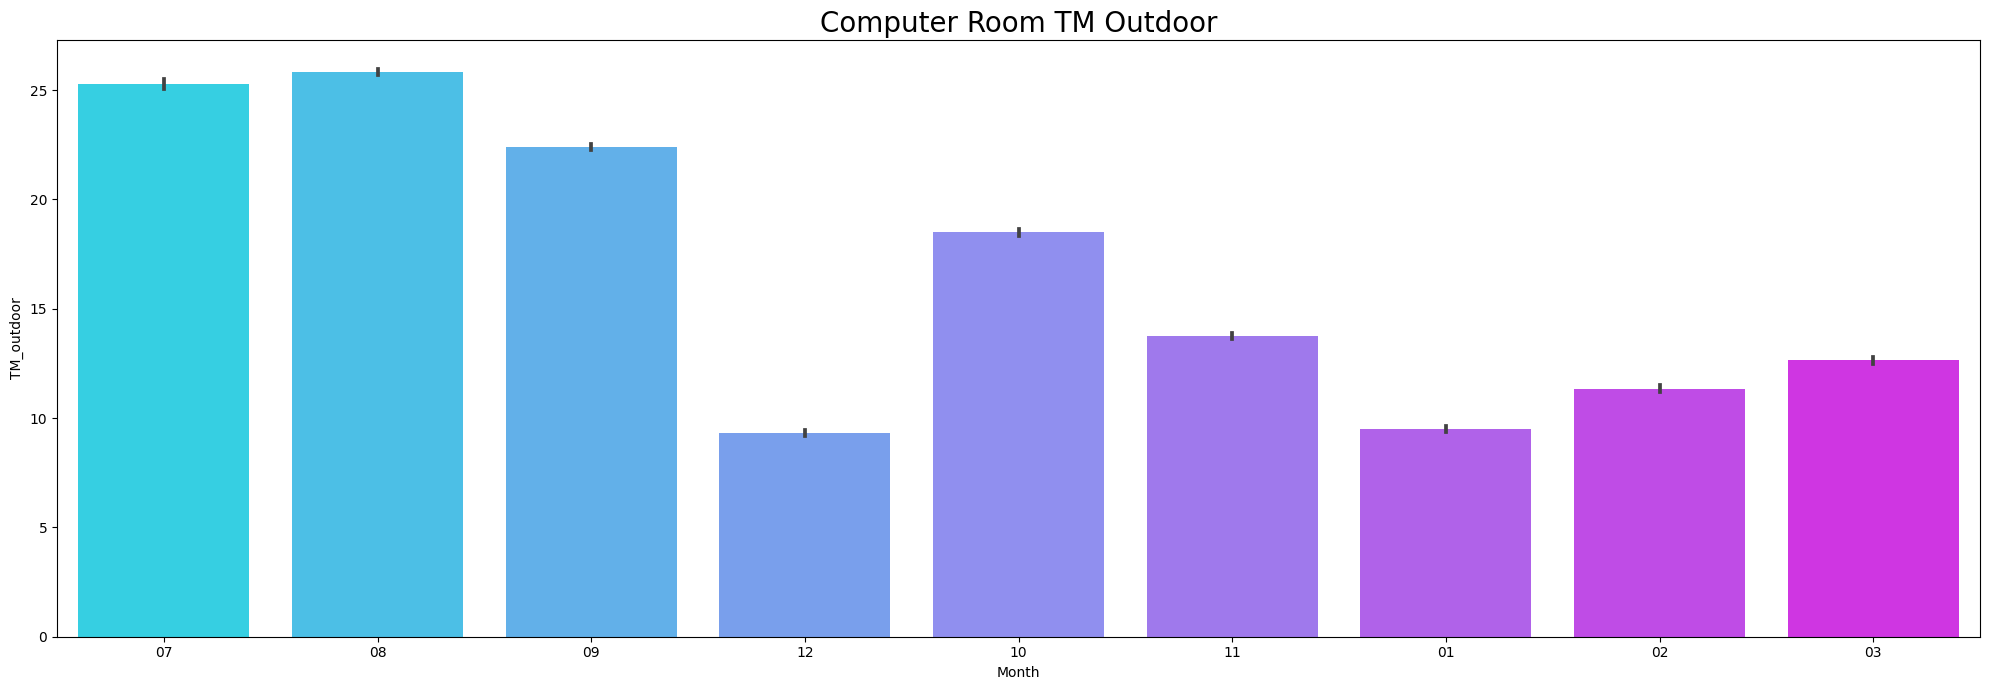

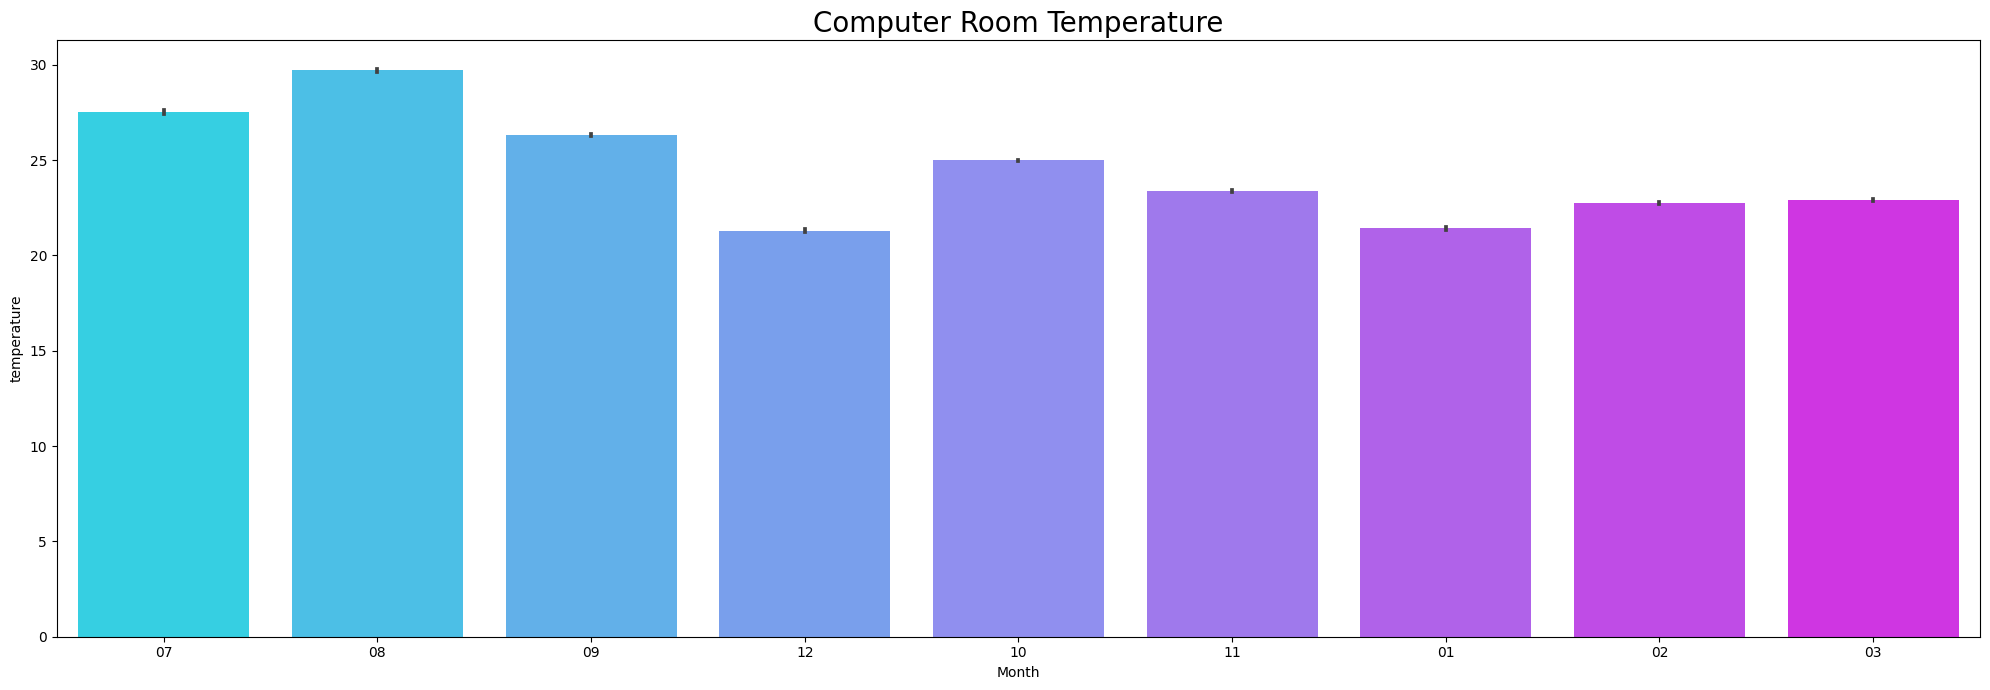

In [16]:
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['TM_outdoor'], "Computer Room TM Outdoor")
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['temperature'], "Computer Room Temperature")

In [17]:
# Test for normality, multimodality (Hartigan's Dip Test), and far outliers (Tukey's test)
table = TableOne(Computer_Room_com.drop(['Day', 'Month', 'Year','Hour', "Minutes", "o3"], axis = 1), dip_test=True, normal_test=True, tukey_test=True)
table

Missing        Overall
n                                             31489
Season, n (%)          0.0         0   11225 (35.6)
                       1.0              3355 (10.7)
                       2.0              5347 (17.0)
                       3.0             11562 (36.7)
Time_of_Day, n (%)     0.0         0    7940 (25.2)
                       1.0              5232 (16.6)
                       2.0              9196 (29.2)
                       3.0              9121 (29.0)
light_level, n (%)     0.0        14   23412 (74.4)
                       1.0              4313 (13.7)
                       2.0               1137 (3.6)
                       3.0                949 (3.0)
                       4.0               1664 (5.3)
co2, mean (SD)                     0   451.2 (90.4)
humidity, n (%)        22.0        0        1 (0.0)
                       22.5                 8 (0.0)
                       23.0                22 (0.1)
                       23.5                39 (0.1)
                       24.0                39 (0.1)
                       24.5                44 (0.1)
                       25.0                93 (0.3)
                       25.5               159 (0.5)
                       26.0               209 (0.7)
                       26.5               304 (1.0)
                       27.0               310 (1.0)
                       27.5               350 (1.1)
                       28.0               298 (0.9)
                       28.5               324 (1.0)
                       29.0               400 (1.3)
                       29.5               532 (1.7)
                       30.0               494 (1.6)
                       30.5               567 (1.8)
                       31.0               619 (2.0)
                       31.5               610 (1.9)
                       32.0               592 (1.9)
                       32.5               765 (2.4)
                       33.0               826 (2.6)
                       33.5               890 (2.8)
                       34.0               972 (3.1)
                       34.5               792 (2.5)
                       35.0               664 (2.1)
                       35.5               528 (1.7)
                       36.0               570 (1.8)
                       36.5               551 (1.7)
                       36.75                1 (0.0)
                       37.0               493 (1.6)
                       37.25                1 (0.0)
                       37.5               682 (2.2)
                       38.0               819 (2.6)
                       38.25                1 (0.0)
                       38.5               680 (2.2)
                       39.0               627 (2.0)
                       39.5               700 (2.2)
                       40.0               587 (1.9)
                       40.5               551 (1.7)
                       41.0               631 (2.0)
                       41.5               752 (2.4)
                       41.75                1 (0.0)
                       42.0               797 (2.5)
                       42.5               736 (2.3)
                       43.0               685 (2.2)
                       43.5               613 (1.9)
                       44.0               434 (1.4)
                       44.5               378 (1.2)
                       45.0               394 (1.3)
                       45.5               495 (1.6)
                       46.0               457 (1.5)
                       46.5               528 (1.7)
                       47.0               497 (1.6)
                       47.5               333 (1.1)
                       48.0               354 (1.1)
                       48.5               325 (1.0)
                       49.0               284 (0.9)
                       49.5               314 (1.0)
                       50.0               322 (1.0)
                       50

Tukey test indicates far outliers

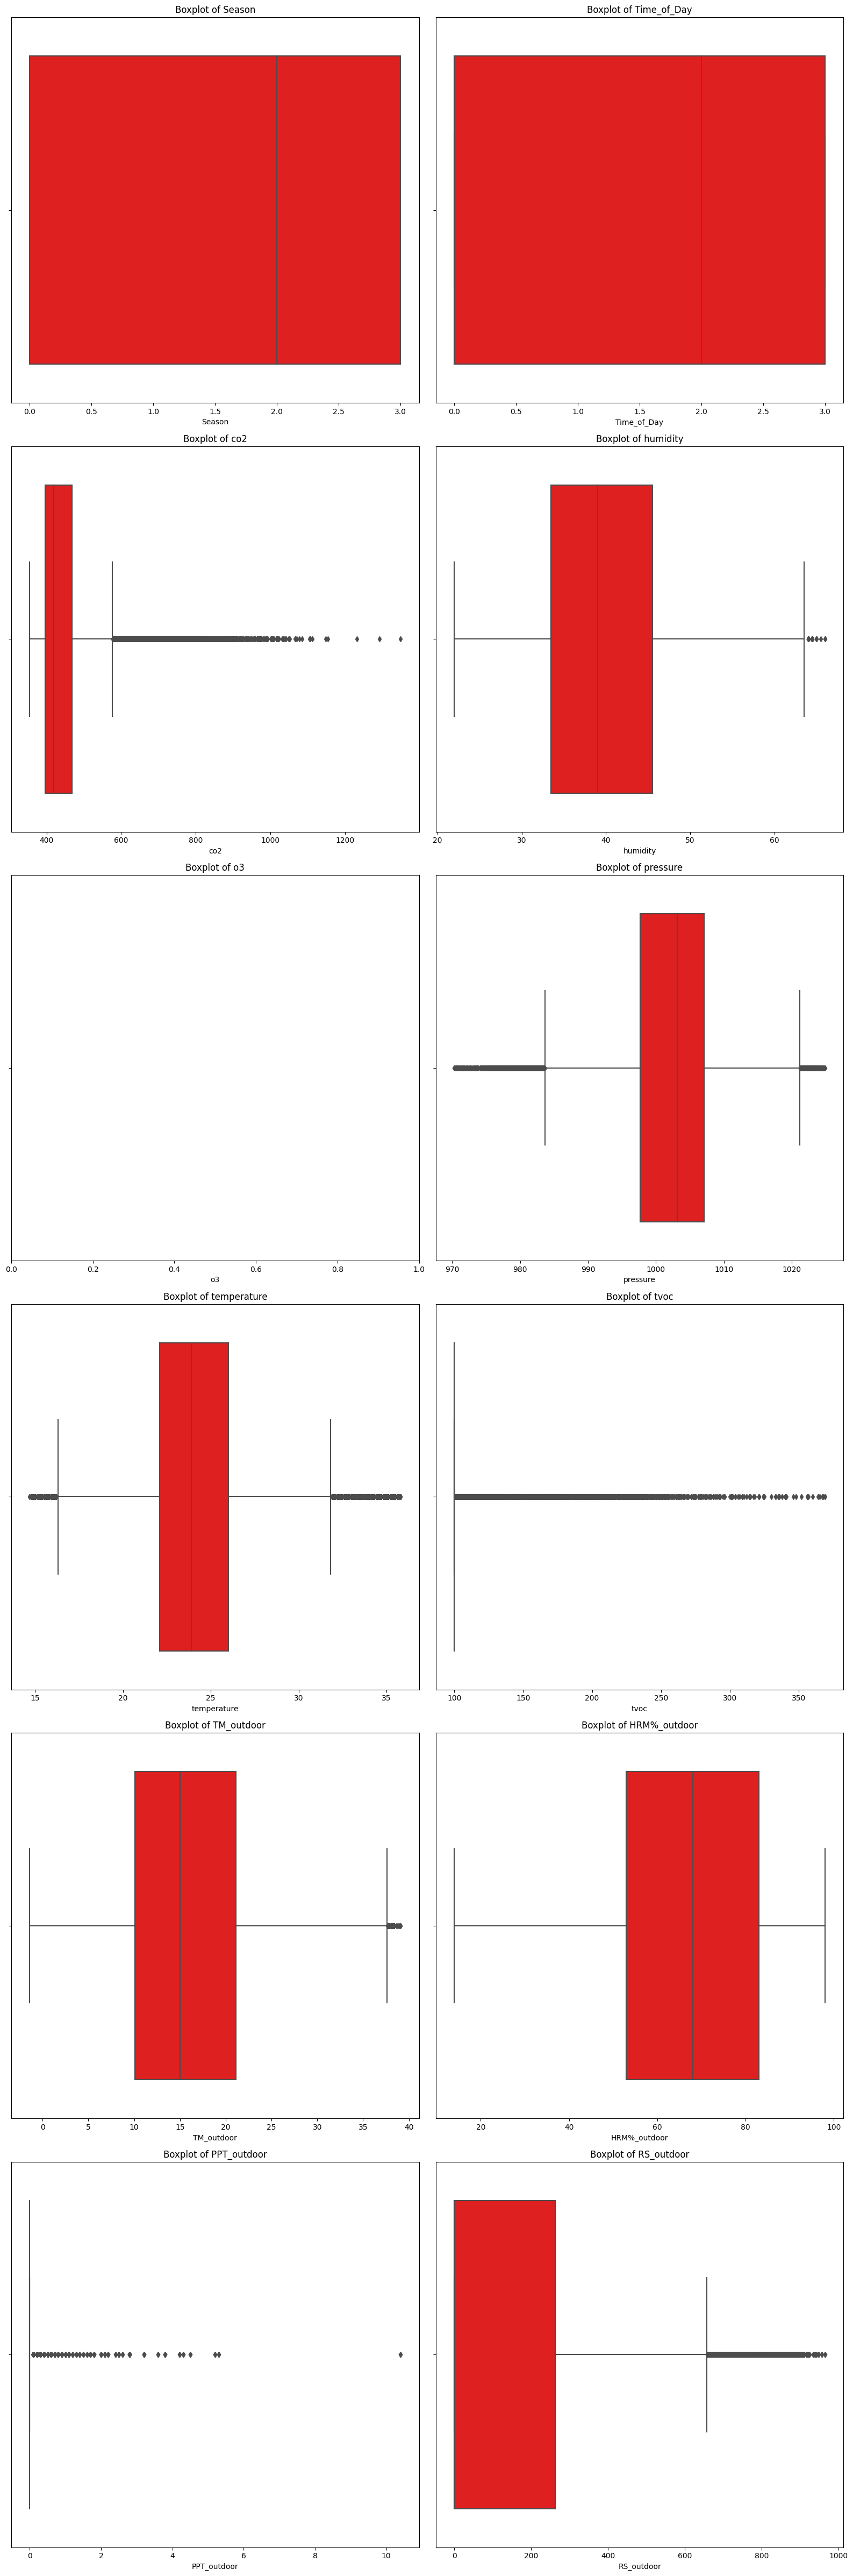

"Q1 = Computer_Room_com['co2'].quantile(0.25)\nQ3 = Computer_Room_com['co2'].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\noutliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]\n\noutliers_co2"

In [14]:
display_outliers(Computer_Room_com)
"""Q1 = Computer_Room_com['co2'].quantile(0.25)
Q3 = Computer_Room_com['co2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]

outliers_co2"""

Correlations

In [13]:
Computer_Room_com['Day'] = pd.to_numeric(Computer_Room_com['Day'])
Computer_Room_com['Month'] = pd.to_numeric(Computer_Room_com['Month'])
Computer_Room_com['Year'] = pd.to_numeric(Computer_Room_com['Year'])
Computer_Room_com['Hour'] = pd.to_numeric(Computer_Room_com['Hour'])
Computer_Room_com['Minutes'] = pd.to_numeric(Computer_Room_com['Minutes'])

<AxesSubplot:>

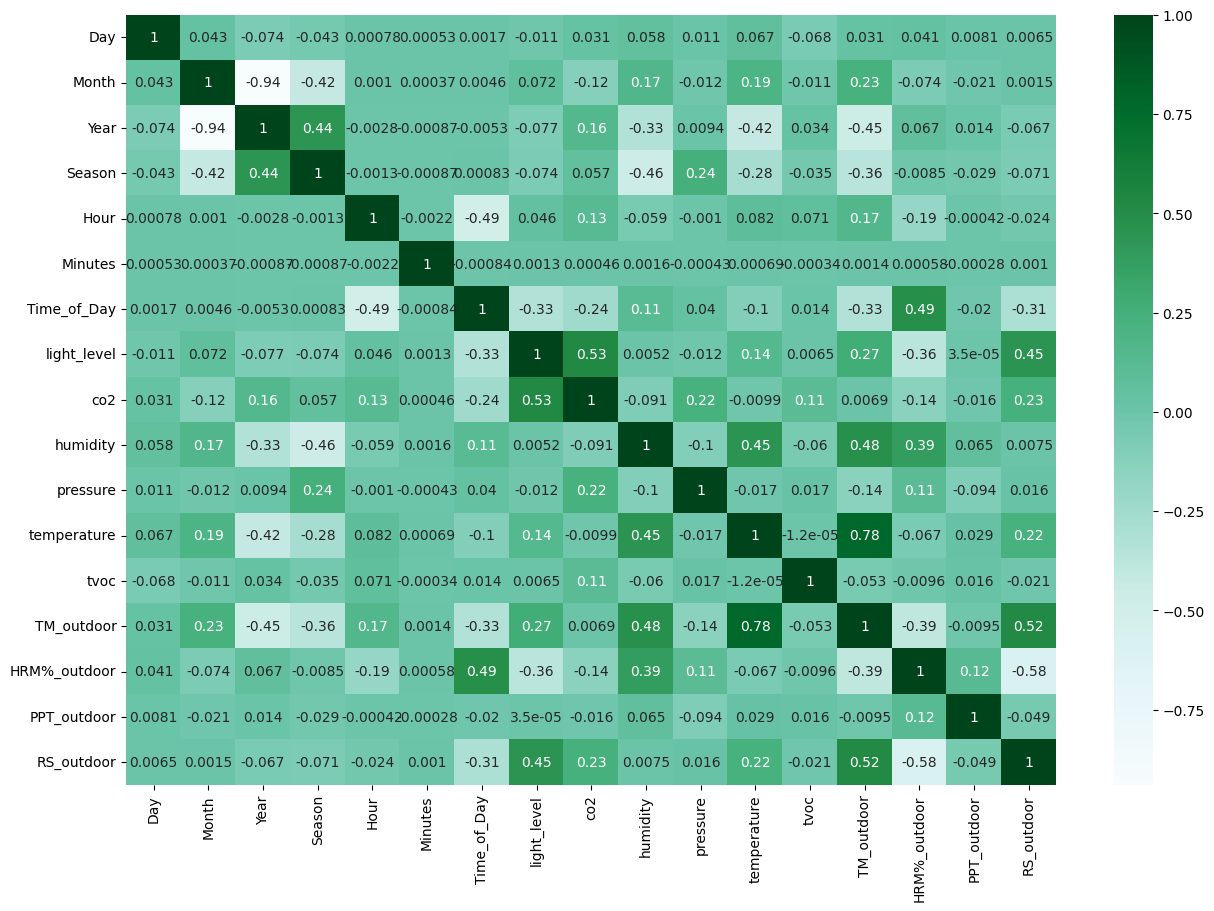

In [14]:
plt.figure(figsize=(15, 10))
sb.heatmap(Computer_Room_com.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)

It can be seen that the columns co2, pressure, tvoc do not have a correlation with any of the other variables. This is because they are totally independent and are not affected by the others.

Since, for example, the CO2 and TVOC columns are variables related to the air quality of the room itself.

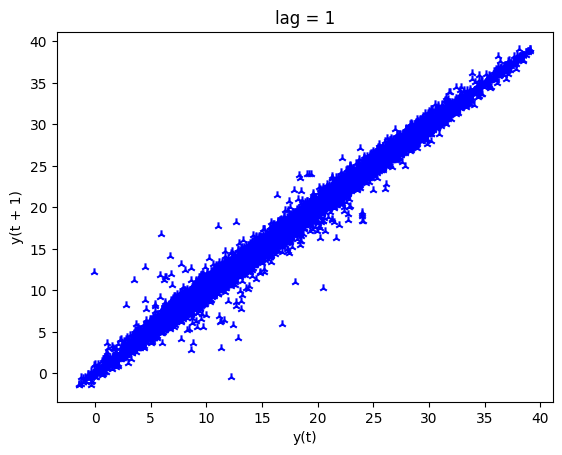

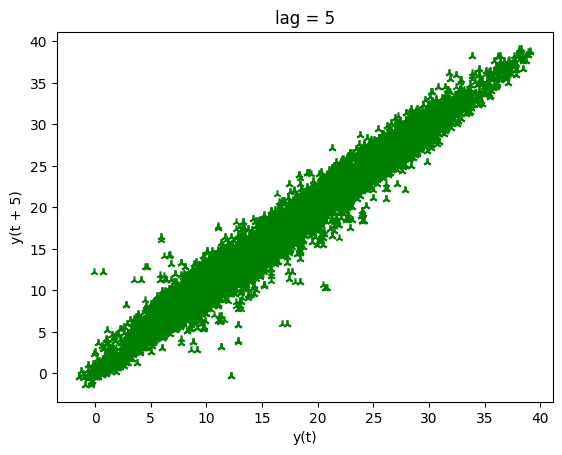

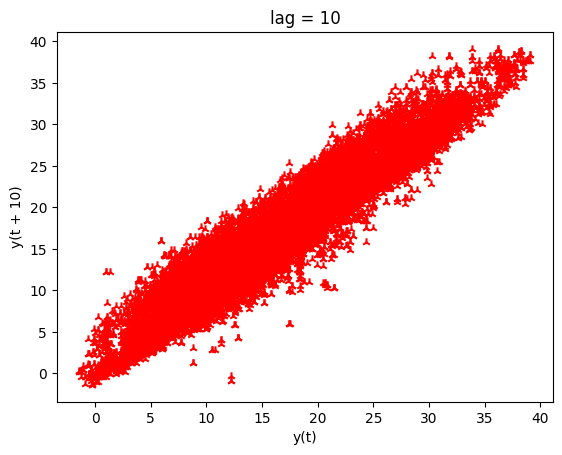

In [16]:
from pandas.plotting import lag_plot
plt.figure()
lag_plot(Computer_Room_com['TM_outdoor'], lag=1, marker='2', c='blue')
plt.title('lag = 1')
plt.figure()
lag_plot(Computer_Room_com['TM_outdoor'], lag=5, marker='2', c='green')
plt.title('lag = 5');
plt.figure()
lag_plot(Computer_Room_com['TM_outdoor'], lag=10, marker='2', c='red')
plt.title('lag = 10');

In [10]:
Computer_Room_com

,Day,Month,Year,Season,Hour,Minutes,Time_of_Day,light_level,co2,humidity,o3,pressure,temperature,tvoc,TM_outdoor,HRM%_outdoor,PPT_outdoor,RS_outdoor
0,25,07,2023,2.0,13,50,0.0,1.0,431.0,37.0,NaN,997.6,27.4,100.0,31.0,25,0.0,808
1,25,07,2023,2.0,14,00,0.0,1.0,426.0,37.0,NaN,997.5,27.5,100.0,31.0,25,0.0,808
2,25,07,2023,2.0,14,10,0.0,1.0,438.0,37.0,NaN,997.6,27.5,100.0,31.0,25,0.0,808
3,25,07,2023,2.0,14,20,0.0,1.0,425.0,37.0,NaN,997.6,27.5,100.0,31.2,25,0.0,746
4,25,07,2023,2.0,14,30,0.0,1.0,442.0,36.5,NaN,997.5,27.6,100.0,31.2,25,0.0,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31484,30,03,2024,1.0,11,40,2.0,0.0,405.0,38.0,NaN,985.0,22.2,100.0,15.4,44,0.0,340
31485,30,03,2024,1.0,11,50,2.0,0.0,399.0,37.5,NaN,985.1,22.4,100.0,15.0,47,0.0,340
31486,30,03,2024,1.0,12,00,0.0,0.0,403.0,37.0,NaN,985.1,22.6,100.0,15.0,47,0.0,340
31487,30,03,2024,1.0,12,10,0.0,0.0,398.0,36.5,NaN,985.2,22.8,100.0,15.0,47,0.0,340


## Bidirectional and Unidirectional LSTM

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

class NNPredictionModel:
    def __init__(self, input_shape, output_units=3):
        self.temperature_model_1 = self.uni_LSTM(input_shape, output_units)
        self.temperature_model_2 = self.bi_LSTM(input_shape, output_units)
        self.temperature_model_3 = self.uni2_LSTM(input_shape, output_units)
        #self.quality_air_model_1 = self.

    def uni_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(64, activation='tanh', return_sequences=True),
            Dropout(0.2),
            LSTM(64, activation='tanh'),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='mse')
        return model
    
    def uni2_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)),
            Dropout(0.5),
            LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01)),
            Dropout(0.5),
            LSTM(64, activation='tanh', kernel_regularizer=l2(0.01)),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def bi_LSTM(self, input_shape, output_units):
        model_bi = Sequential([
            Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
            Dense(20, activation='tanh'),
            tf.keras.layers.Dropout(0.20),
            Dense(output_units, activation = 'linear'),
        ])
        model_bi.compile(optimizer='adam', loss='mse')
        return model_bi

In [11]:
def model_train_evaluation(y, X, model, model_name):
    #Model run
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #history = model.fit(X_train,y_train, epochs=6,validation_data=(X_val, y_val),callbacks=early_stop)
    history = model.fit(X_train,y_train, epochs=30,validation_split=0.001)#, callbacks=early_stop)
    history_frame = pd.DataFrame(history.history)
    
    # model performance plot
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()
    
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    ypred =model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('Indoor Temperature in celsius')
    plt.ylabel('Indoor Temperature in celsius')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()

## Temperature Prediction

In [28]:
df_train=Computer_Room_com[["Month",'Season',"Hour","Minutes","Time_of_Day","light_level","humidity",'HRM%_outdoor','RS_outdoor', "TM_outdoor","temperature"]]
print(len(df_train.columns))

11


In [29]:
df_train

,Month,Season,Hour,Minutes,Time_of_Day,light_level,humidity,HRM%_outdoor,RS_outdoor,TM_outdoor,temperature
0,7,2.0,13,50,0.0,1.0,37.0,25,808,31.0,27.4
1,7,2.0,14,0,0.0,1.0,37.0,25,808,31.0,27.5
2,7,2.0,14,10,0.0,1.0,37.0,25,808,31.0,27.5
3,7,2.0,14,20,0.0,1.0,37.0,25,746,31.2,27.5
4,7,2.0,14,30,0.0,1.0,36.5,25,746,31.2,27.6
...,...,...,...,...,...,...,...,...,...,...,...
31484,3,1.0,11,40,2.0,0.0,38.0,44,340,15.4,22.2
31485,3,1.0,11,50,2.0,0.0,37.5,47,340,15.0,22.4
31486,3,1.0,12,0,0.0,0.0,37.0,47,340,15.0,22.6
31487,3,1.0,12,10,0.0,0.0,36.5,47,340,15.0,22.8


In [30]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [31]:
df_train = df_train.fillna(0)

In [32]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

Series([], dtype: float64)


In [34]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

(31489, 11)

In [35]:
lags=10
forecasts=3
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 11), (31476, 10, 11), (31476, 3))

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25180, 10, 11), (25180, 3), (6296, 10, 11), (6296, 3))

In [37]:
X_train, y_train, X_val, y_val

(array([[[ 0.19897416,  0.34741975,  0.79649627, ..., -0.0392621 ,
           1.13150334,  0.51189149],
         [ 0.19897416,  0.34741975,  0.79649627, ..., -0.3980003 ,
           0.99953964,  0.39493229],
         [ 0.19897416,  0.34741975,  0.79649627, ..., -0.3980003 ,
           0.99953964,  0.36569249],
         ...,
         [ 0.19897416,  0.34741975,  0.94132758, ..., -0.65300698,
           0.89396868,  0.1025343 ],
         [ 0.19897416,  0.34741975,  0.94132758, ..., -0.65300698,
           0.89396868,  0.1025343 ],
         [ 0.19897416,  0.34741975,  0.94132758, ..., -0.65300698,
           0.89396868,  0.1025343 ]],
 
        [[ 0.19897416,  0.34741975, -0.94147936, ..., -0.52766471,
           1.32944889,  2.55867746],
         [ 0.19897416,  0.34741975, -0.94147936, ..., -0.52766471,
           1.32944889,  2.55867746],
         [ 0.19897416,  0.34741975, -0.94147936, ..., -0.52766471,
           1.32944889,  2.55867746],
         ...,
         [ 0.19897416,  0.3474197

In [42]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=3)
uni_model = model.temperature_model_1
bi_model = model.temperature_model_2
uni2_model = model.temperature_model_3

bi_model.summary()
tf.keras.utils.plot_model(bi_model)

uni_model.summary()
tf.keras.utils.plot_model(uni_model)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 10, 512)        │       548,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10, 20)         │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 10, 256)        │       152,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10, 20)         │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 256)            │       152,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 874,619 (3.34 MB)

 Trainable params: 874,619 (3.34 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,307 (602.76 KB)

 Trainable params: 154,307 (602.76 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional 1 LSTM model')

Epoch 1/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 0.1246 - val_loss: 0.0145
Epoch 2/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0327 - val_loss: 0.0130
Epoch 3/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - loss: 0.0253 - val_loss: 0.0094
Epoch 4/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0221 - val_loss: 0.0110
Epoch 5/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0210 - val_loss: 0.0133
Epoch 6/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0200 - val_loss: 0.0051
Epoch 7/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0184 - val_loss: 0.0068
Epoch 8/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0203 - val_loss: 0.0078
Epoch 9/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.0192 - val_loss: 0.0032
Epoch 10/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0194 - val_loss: 0.0141
Epoch 11/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - loss: 0.0196 - val_loss: 0.0069
Epoch 12/30
787/787 ━━━━━━━━━━

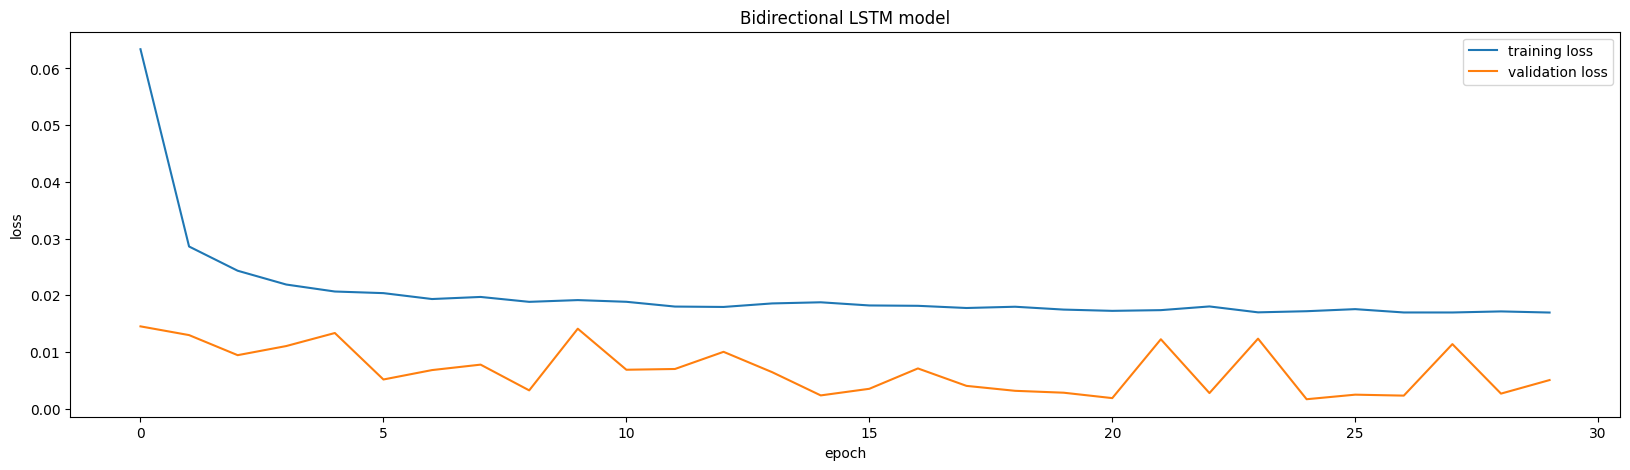

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.05029745558885698
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.005275851476930511
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.07248688216001936
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.19220349404546533
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.9948788118153257
R2 of Bidirectional LSTM model : 0.99

 



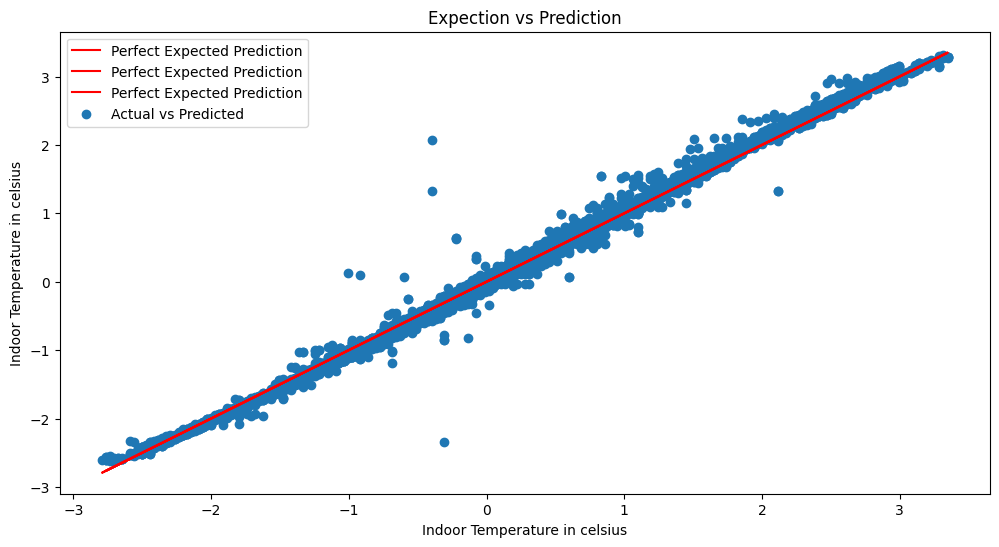

In [44]:
model_train_evaluation(y_val, X_val,bi_model, 'Bidirectional LSTM model')

Epoch 1/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.1239 - val_loss: 0.0437
Epoch 2/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0412 - val_loss: 0.0413
Epoch 3/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0348 - val_loss: 0.0380
Epoch 4/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0295 - val_loss: 0.0322
Epoch 5/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0307 - val_loss: 0.0306
Epoch 6/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0278 - val_loss: 0.0299
Epoch 7/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0276 - val_loss: 0.0239
Epoch 8/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0260 - val_loss: 0.0389
Epoch 9/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0247 - val_loss: 0.0263
Epoch 10/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0252 - val_loss: 0.0471
Epoch 11/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0227 - val_loss: 0.0229
Epoch 12/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 7s 8

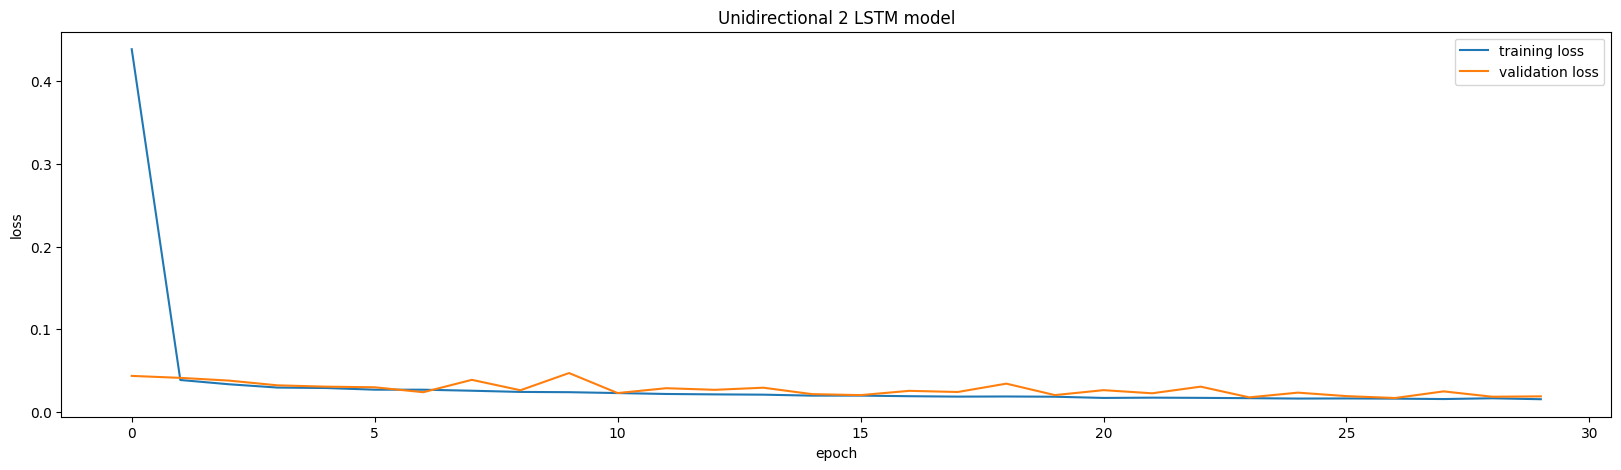

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional 2 LSTM model : 0.05965179501688542
Mean Squared Error(MSE) of Unidirectional 2 LSTM model : 0.008251265682703124
Root Mean Squared Error (RMSE) of Unidirectional 2 LSTM model : 0.09062424453388174
Mean absolute percentage error (MAPE) of Unidirectional 2 LSTM model : 0.3276212905695091
Explained Variance Score (EVS) of Unidirectional 2 LSTM model : 0.9923969326762246
R2 of Unidirectional 2 LSTM model : 0.99

 



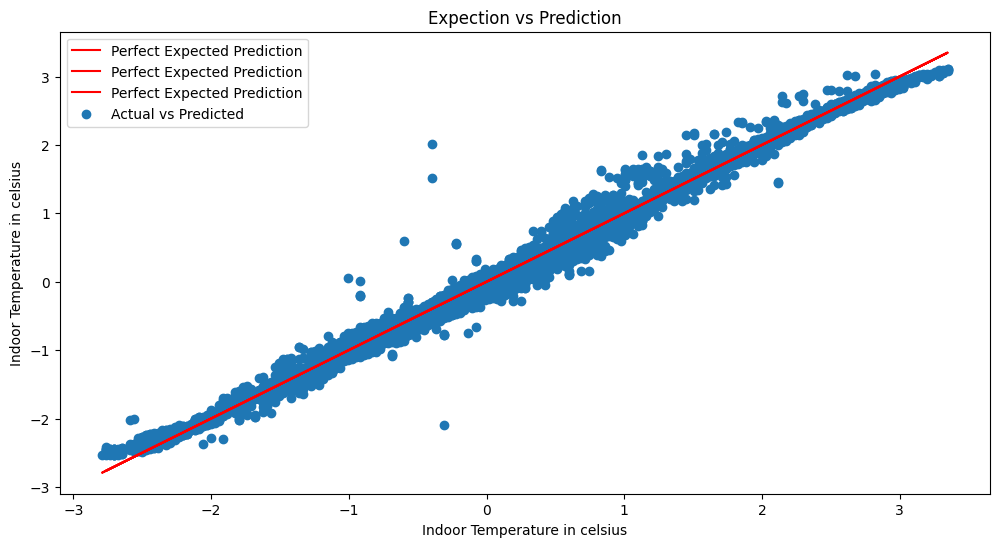

In [45]:
model_train_evaluation(y_val, X_val, uni2_model, 'Unidirectional 2 LSTM model')

In [79]:
import pandas as pd

data_test = {
    'Day': ['09','09', '09', '09', '09', '09', '09', '09', '09', '09'],
    'Hour': ['14', '14', '14', '14', '14', '14', '15', '15', '15', '15'],
    'Minutes': ['00', '10', '20', '30', '40', '50', '00', '10', '20', '30'],
    'Season': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'Time_of_Day': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'light_level': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
}

df_new = pd.DataFrame(data_test)

In [80]:
df_test=df_new[['Day', "Hour", "Minutes", 'Season',"Time_of_Day"]]
df_test

,Day,Hour,Minutes,Season,Time_of_Day
0,09,14,00,1.0,0.0
1,09,14,10,1.0,0.0
2,09,14,20,1.0,0.0
3,09,14,30,1.0,0.0
4,09,14,40,1.0,0.0
5,09,14,50,1.0,0.0
6,09,15,00,1.0,0.0
7,09,15,10,1.0,0.0
8,09,15,20,1.0,0.0
9,09,15,30,1.0,0.0


In [81]:
train_test=df_train.append(df_test,ignore_index=True).fillna(0)
train_test

C:\Users\migue\AppData\Local\Temp\ipykernel_21256\237083430.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test=df_train.append(df_test,ignore_index=True).fillna(0)


,Day,Hour,Minutes,Season,Time_of_Day,humidity,HRM%_outdoor,RS_outdoor,temperature,TM_outdoor
0,25,13,50,2.0,0.0,37.0,25.0,808.0,27.4,31.0
1,25,14,00,2.0,0.0,37.0,25.0,808.0,27.5,31.0
2,25,14,10,2.0,0.0,37.0,25.0,808.0,27.5,31.0
3,25,14,20,2.0,0.0,37.0,25.0,746.0,27.5,31.2
4,25,14,30,2.0,0.0,36.5,25.0,746.0,27.6,31.2
...,...,...,...,...,...,...,...,...,...,...
31494,09,14,50,1.0,0.0,0.0,0.0,0.0,0.0,0.0
31495,09,15,00,1.0,0.0,0.0,0.0,0.0,0.0,0.0
31496,09,15,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0
31497,09,15,20,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
y_mean=df_train['TM_outdoor'].mean()
y_std=scaler.scale_[df_train.shape[1]-1]
y_mean, y_std

(15.825647051351265, 7.577841481704633)

In [83]:
for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=uni_model.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std*val[:,0]+y_mean
    train_test.loc[i,'TM_outdoor']=val2
    
final_test = train_test[len(df_train):][['TM_outdoor']]
final_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,TM_outdoor
31489,15.212444
31490,15.436777
31491,15.879521
31492,16.600454
31493,17.641096
31494,18.749802
31495,19.767925
31496,20.503305
31497,21.301210
31498,21.803207


In [41]:
def mean_std(train_test, column, position):
    # Obtener las últimas n columnas del DataFrame
    y_mean=train_test[column].mean()
    y_std=scaler.scale_[train_test.shape[1]-position]
    
    return y_mean, y_std

## Quality-Air Prediction co2

In [34]:
df_train=Computer_Room_com[["Day",'Season',"Hour","Minutes","light_level","co2"]]
print(len(df_train.columns))#RS_outdoor

6


In [35]:
df_train

,Day,Season,Hour,Minutes,light_level,co2
0,25,2.0,13,50,1.0,431.0
1,25,2.0,14,00,1.0,426.0
2,25,2.0,14,10,1.0,438.0
3,25,2.0,14,20,1.0,425.0
4,25,2.0,14,30,1.0,442.0
...,...,...,...,...,...,...
31484,30,1.0,11,40,0.0,405.0
31485,30,1.0,11,50,0.0,399.0
31486,30,1.0,12,00,0.0,403.0
31487,30,1.0,12,10,0.0,398.0


In [36]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [37]:
df_train = df_train.fillna(0)

In [38]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

Series([], dtype: float64)


In [39]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

(31489, 6)

In [40]:
lags=8
forecasts= 1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 6), (31480, 8, 6), (31480, 1))

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25184, 8, 6), (25184, 1), (6296, 8, 6), (6296, 1))

In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

class NNPredictionModel:
    def __init__(self, input_shape, output_units=3):
        self.temperature_model_1 = self.uni_LSTM(input_shape, output_units)
        self.temperature_model_2 = self.bi_LSTM(input_shape, output_units)
        #self.quality_air_model_1 = self.

    def uni_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(64, activation='tanh', kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def bi_LSTM(self, input_shape, output_units):
        model_bi = Sequential([
            Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            #tf.keras.layers.Dropout(0.3),
            Dense(output_units, activation = 'linear'),
        ])
        model_bi.compile(optimizer='adam', loss='mse')
        return model_bi

In [43]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.temperature_model_1
bi_model = model.temperature_model_2

#bi_model.summary()
#tf.keras.utils.plot_model(bi_model)
#uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
def model_train_evaluation(y, X, model, model_name):
    #Model run
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

    #history = model.fit(X_train,y_train, epochs=6,validation_data=(X_val, y_val),callbacks=early_stop)
    history = model.fit(X_train,y_train, epochs=100,validation_split=0.001, callbacks=[early_stop, reduce_lr])
    
    # model performance plot
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()
    
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    ypred =model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('co2')
    plt.ylabel('co2')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()

Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 3.4224 - val_loss: 0.6268 - learning_rate: 0.0010
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5489 - val_loss: 0.1625 - learning_rate: 0.0010
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.2255 - val_loss: 0.1049 - learning_rate: 0.0010
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.1758 - val_loss: 0.0942 - learning_rate: 0.0010
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.1786 - val_loss: 0.0894 - learning_rate: 0.0010
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.1470 - val_loss: 0.1368 - learning_rate: 0.0010
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.1562 - val_loss: 0.0879 - learning_rate: 0.0010
Epoch 8/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.1481 - val_loss: 0.1029 - learning_rate: 0.0010
Epoch 9/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.1461 - val_loss: 0.0944 - learn

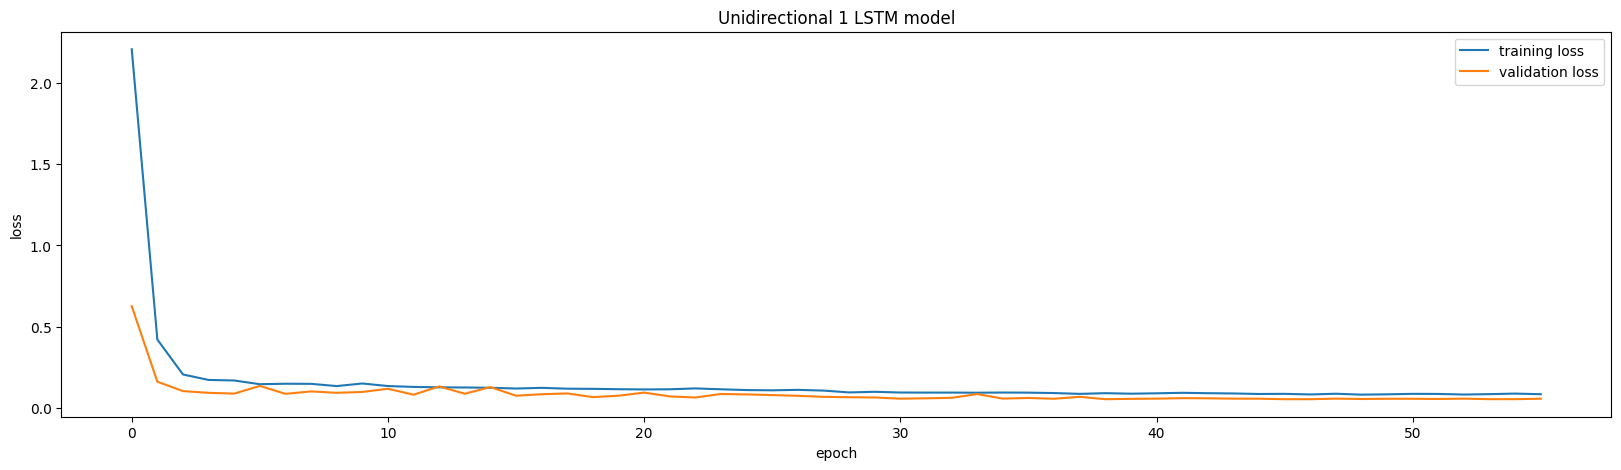

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional 1 LSTM model : 0.11677021975647583
Mean Squared Error(MSE) of Unidirectional 1 LSTM model : 0.04533023158345947
Root Mean Squared Error (RMSE) of Unidirectional 1 LSTM model : 0.212908974877668
Mean absolute percentage error (MAPE) of Unidirectional 1 LSTM model : 0.6515201227671625
Explained Variance Score (EVS) of Unidirectional 1 LSTM model : 0.9528268442085659
R2 of Unidirectional 1 LSTM model : 0.95

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


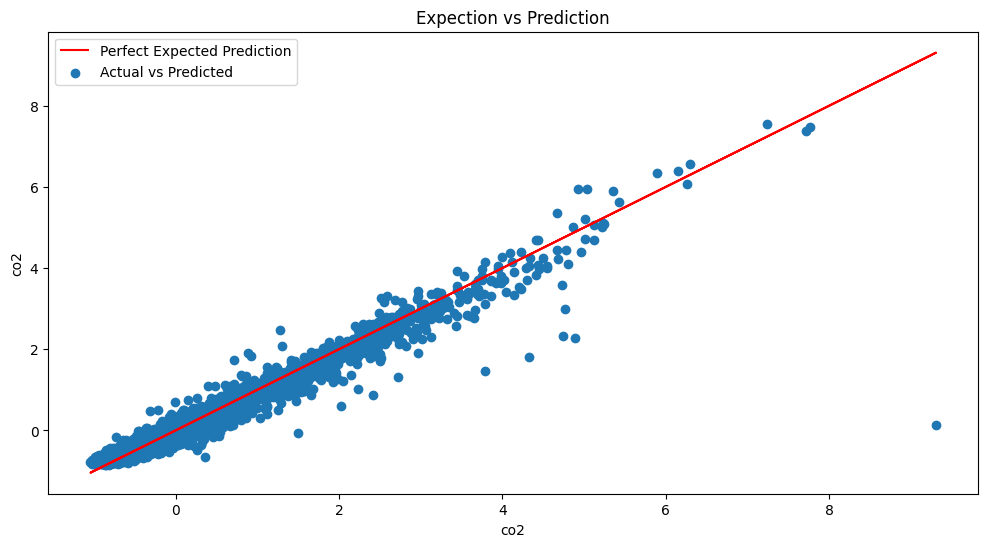

In [45]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional 1 LSTM model')

Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.6369 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.1639 - val_loss: 0.0665 - learning_rate: 0.0010
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.1432 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.1349 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.1344 - val_loss: 0.1987 - learning_rate: 0.0010
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.1336 - val_loss: 0.0931 - learning_rate: 0.0010
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.1256 - val_loss: 0.0527 - learning_rate: 0.0010
Epoch 8/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.1315 - val_loss: 0.0607 - learning_rate: 0.0010
Epoch 9/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.1229 - val_loss: 0.0797 - learn

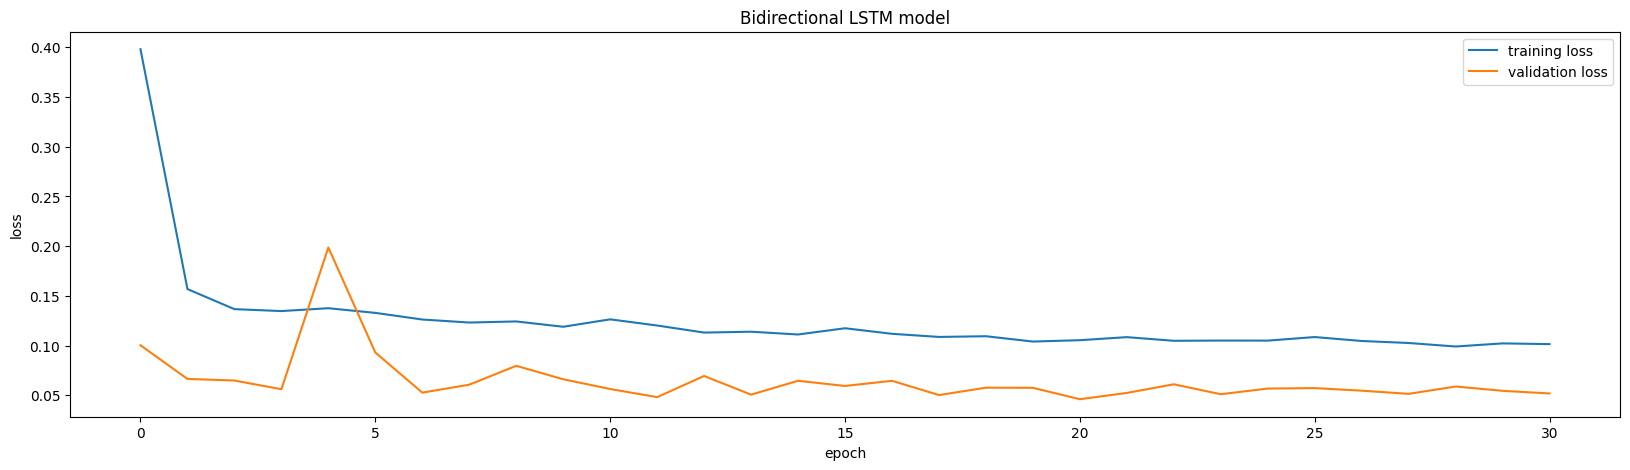

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.1374691908803906
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.05781902651742995
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.24045587228726595
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.7747794925730221
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.940191560311884
R2 of Bidirectional LSTM model : 0.94

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


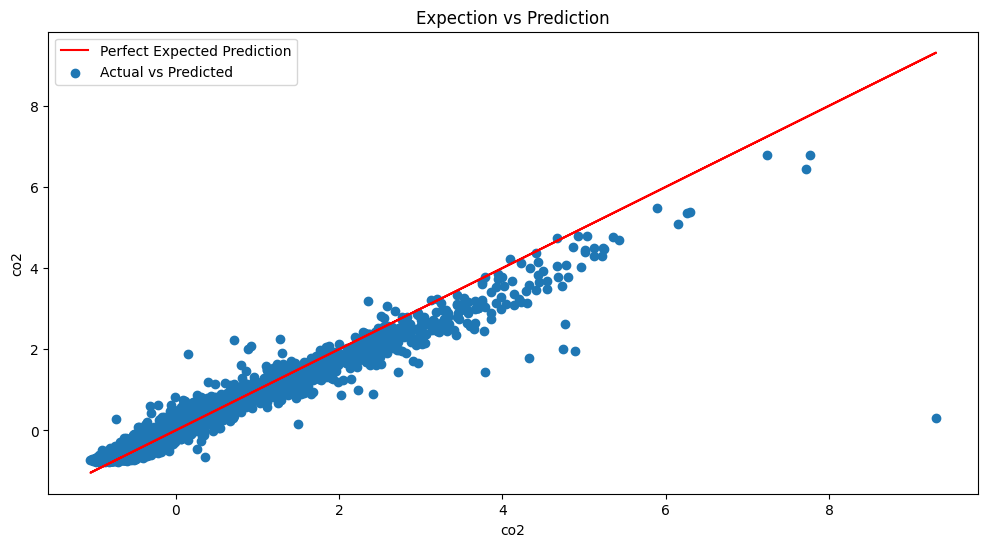

In [46]:
model_train_evaluation(y_val, X_val, bi_model, 'Bidirectional LSTM model')

## Quality-Air Prediction tvoc

In [11]:
df_train=Computer_Room_com[["Day","Hour","Minutes","Time_of_Day","light_level","tvoc"]]
print(len(df_train.columns))

6


In [12]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [13]:
df_train = df_train.fillna(0)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

(31489, 6)

In [15]:
lags=8
forecasts= 1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 6), (31480, 8, 6), (31480, 1))

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25184, 8, 6), (25184, 1), (6296, 8, 6), (6296, 1))

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

class NNPredictionModel:
    def __init__(self, input_shape, output_units=3):
        self.temperature_model_1 = self.uni_LSTM(input_shape, output_units)
        self.temperature_model_2 = self.bi_LSTM(input_shape, output_units)
        #self.quality_air_model_1 = self.

    def uni_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(64, activation='tanh', kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def bi_LSTM(self, input_shape, output_units):
        model_bi = Sequential([
            Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            #tf.keras.layers.Dropout(0.3),
            Dense(output_units, activation = 'linear'),
        ])
        model_bi.compile(optimizer='adam', loss='mse')
        return model_bi

In [18]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.temperature_model_1
bi_model = model.temperature_model_2

#bi_model.summary()
#tf.keras.utils.plot_model(bi_model)
#uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
def model_train_evaluation(y, X, model, model_name):
    #Model run
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

    #history = model.fit(X_train,y_train, epochs=6,validation_data=(X_val, y_val),callbacks=early_stop)
    history = model.fit(X_train,y_train, epochs=100,validation_split=0.001, callbacks=[early_stop, reduce_lr])
    
    # model performance plot
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()
    
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    ypred =model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('tvoc')
    plt.ylabel('tvoc')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()

Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 4.2028 - val_loss: 0.9813 - learning_rate: 0.0010
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.9328 - val_loss: 0.2837 - learning_rate: 0.0010
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3961 - val_loss: 0.1388 - learning_rate: 0.0010
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3005 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.2640 - val_loss: 0.0742 - learning_rate: 0.0010
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.2517 - val_loss: 0.0669 - learning_rate: 0.0010
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.2529 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 8/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.2186 - val_loss: 0.0697 - learning_rate: 0.0010
Epoch 9/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.2140 - val_loss: 0.0486 - learning_r

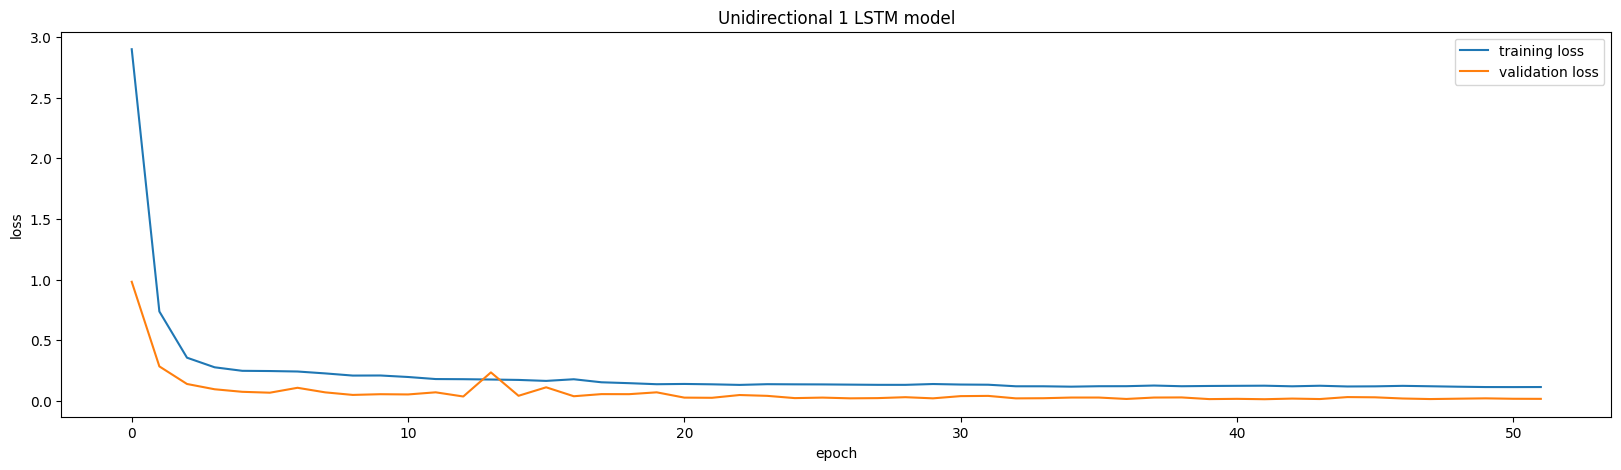

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional 1 LSTM model : 0.08599107161832233
Mean Squared Error(MSE) of Unidirectional 1 LSTM model : 0.07976272098660106
Root Mean Squared Error (RMSE) of Unidirectional 1 LSTM model : 0.28242294699014997
Mean absolute percentage error (MAPE) of Unidirectional 1 LSTM model : 0.38664830554373536
Explained Variance Score (EVS) of Unidirectional 1 LSTM model : 0.9278825509519796
R2 of Unidirectional 1 LSTM model : 0.93

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


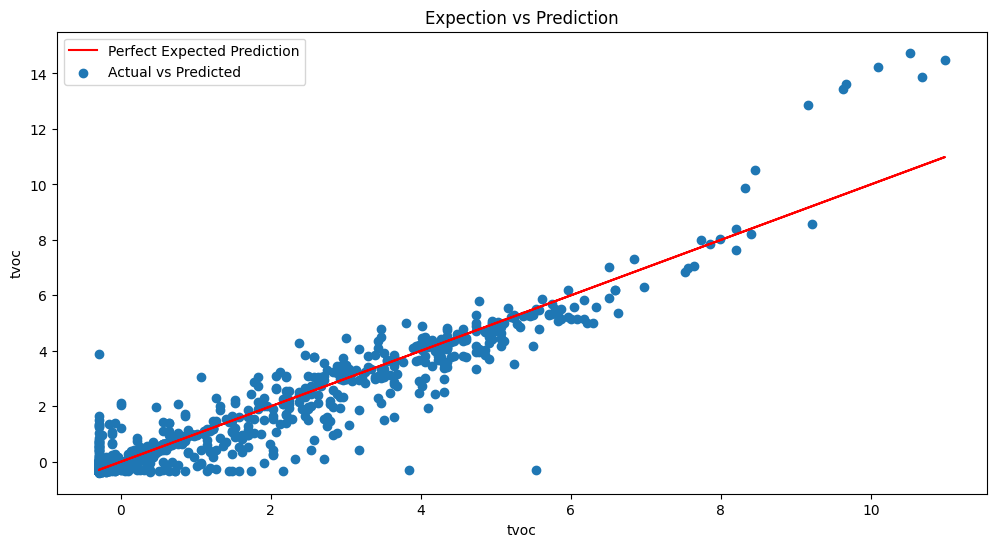

In [20]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional 1 LSTM model')

Epoch 1/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - loss: 0.9909 - val_loss: 0.0498 - learning_rate: 0.0010
Epoch 2/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - loss: 0.2498 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 3/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - loss: 0.2274 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 4/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - loss: 0.2033 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 5/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - loss: 0.1834 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 6/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - loss: 0.1683 - val_loss: 0.0685 - learning_rate: 0.0010
Epoch 7/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - loss: 0.1671 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 8/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 0.1593 - val_loss: 0.0807 - learning_rate: 0.0010
Epoch 9/100
787/787 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 0.1450 - val_loss: 0.0154 - learn

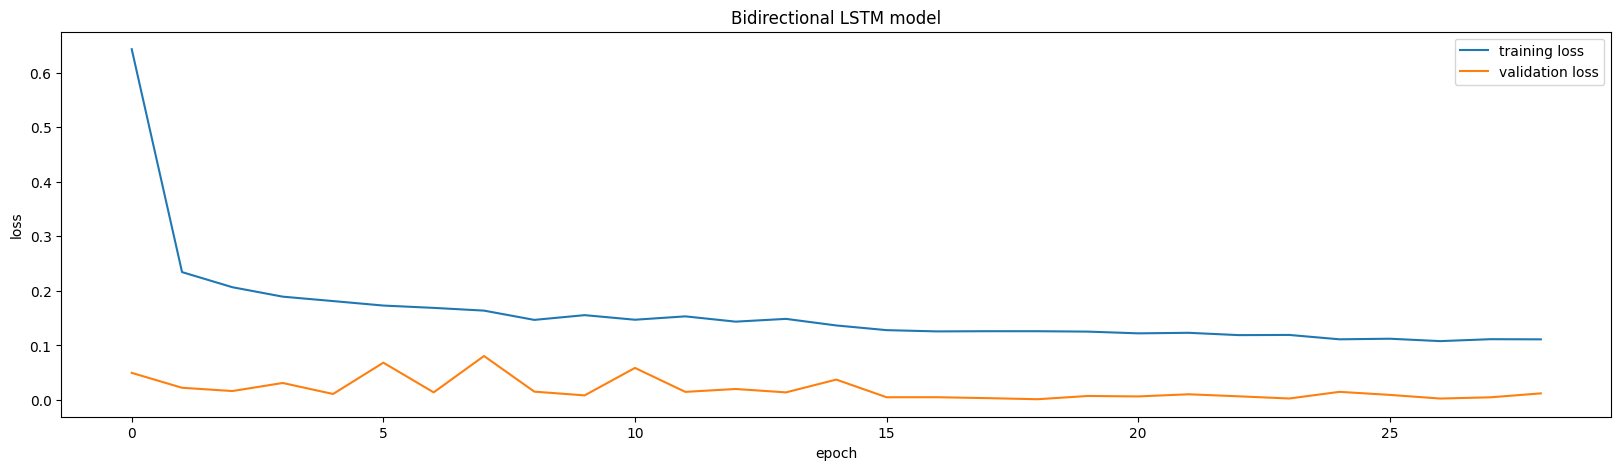

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.07259652584769466
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.08016003831325914
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.28312548156826
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.27433393507149534
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.9270509851219569
R2 of Bidirectional LSTM model : 0.93

 



c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


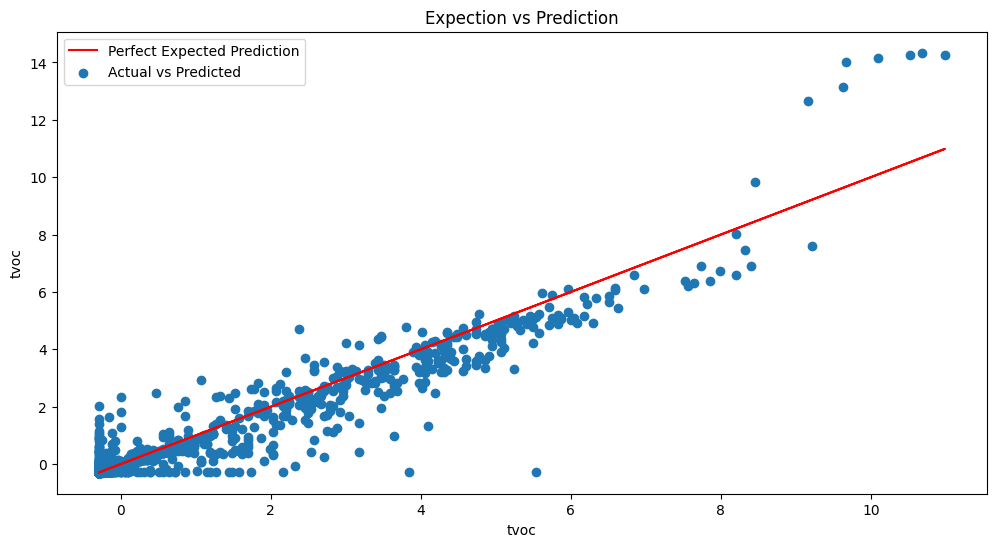

In [21]:
model_train_evaluation(y_val, X_val, bi_model, 'Bidirectional LSTM model')